In [14]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio


mpl.rcParams['figure.figsize'] = [14.0, 6.0]

In [15]:
max_safe_exponent = np.log(2)*(np.finfo(float).maxexp-1)

def bump_function(t, t0, t1):
    """Smooth function going from 0 before t0 to 1 after t1, with C^infty transition in between"""
    assert t0 <= t1
    f = np.zeros_like(t)
    if t0 >= t[-1]:
        return f
    f[t >= (t0+t1)/2] = 1.0
    if t1 <= t[0]:
        return f
    transition_indices = (t0 < t) & (t < t1)
    transition = (t[transition_indices]-t0) / (t1 - t0)
    transition = 1.0/transition - 1.0/(1.0-transition)
    safe_indices = (transition < max_safe_exponent)
    transition_indices[transition_indices] = safe_indices
    f[transition_indices] = 1.0 / (1.0 + np.exp(transition[safe_indices]))
    return f

In [16]:
sampling_rate = 4096.0 # Hz
with h5py.File('Data/H-H1_LOSC_4_V1-1126259446-32.hdf5') as f:
    h = f['strain/Strain'][:]
    # Time of event is 16.4

# sampling_rate = 4096.0 # Hz
# with h5py.File('Data/L-L1_LOSC_4_V1-1126259446-32.hdf5') as f:
#     h = f['strain/Strain'][:]
#     # Time of event is 16.4

# sampling_rate = 4096.0 # Hz
# with h5py.File('Data/H-H1_LOSC_16_V1-1135136334-32.hdf5') as f:
#     h = f['strain/Strain'][:]
#     h = signal.decimate(h, 4, 60, ftype='fir')
#     # Time of event is 16.65

dt = 1/sampling_rate
t = np.arange(len(h)) / sampling_rate
htilde = dt * np.fft.rfft(h)
frequencies = np.fft.rfftfreq(len(h), dt)

In [17]:
def filter_and_plot(htilde, t, dt, sliders, notch_filters, use_equalizer, frequencies, frequency_bin_upper_ends, hide_original_time_domain):
    from IPython.display import display, clear_output, Audio

    # Once new output is available, clear the old output
    clear_output(wait=True)

    # Get levels from sliders
    levels = np.ones_like(frequencies)
    if use_equalizer.value is True:
        slider_values = [s.value for s in sliders]
        for i, f in enumerate(frequency_bin_upper_ends):
            if i==0:
                f_last = 0.0
            levels[(frequencies >= f_last) & (frequencies < f)] = 10**slider_values[i]
            f_last = f

    # Get notch filters (if any)
    for notch_filter in notch_filters.children:
        f_begin, f_end, f_bool = [child.value for child in notch_filter.children if not isinstance(child, widgets.Label)]
        if (f_bool is True) and (f_begin<f_end):
            levels[(frequencies >= f_begin) & (frequencies < f_end)] = 0.0
    
    # Filter the data
    hprime = (1/dt) * np.fft.irfft(htilde*levels)
    
    # Smooth the beginning and end, so there are no loud spikes as the audio turns on and off
    hprime *= bump_function(t, 0, 3.0) * (1-bump_function(t, t[-1]-3.0, t[-1]))
    
    # Plot
    plt.close('all')
    f, (ax1, ax2) = plt.subplots(1, 2)
    if not hide_original_time_domain.value:
        ax1.plot(t, h)
    ax1.plot(t, hprime)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Detector strain $h$ (dimensionless)')
    ax1.set_xlim(xmax=t[-1])
    ax1.set_ylim(1.1*np.max(hprime), 1.1*np.min(hprime))
    ax1.set_title('Time domain')
    ax2.loglog(frequencies, abs(htilde), label='Raw data')
    ax2.loglog(frequencies, abs(htilde*levels), label='Filtered data')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel(r'Detector strain Fourier transform $\tilde{h}$ (seconds)')
    ax2.set_xlim(1, sampling_rate/2)
    ax2.legend(loc='lower left');
    ax2.set_title('Frequency domain')
    f.tight_layout()
    display(Audio(data=hprime, rate=int(1.0/dt), autoplay=False))


def add_notch_filter(notch_filters, gap_filler):
    new_filter = widgets.HBox([widgets.FloatText(description='Begin', width='150px'),
                               widgets.FloatText(description='End', width='150px'),
                               gap_filler,
                               widgets.Checkbox(description='Use filter', value=True)])
    notch_filters.children += (new_filter,)

<IPython.core.display.Javascript object>


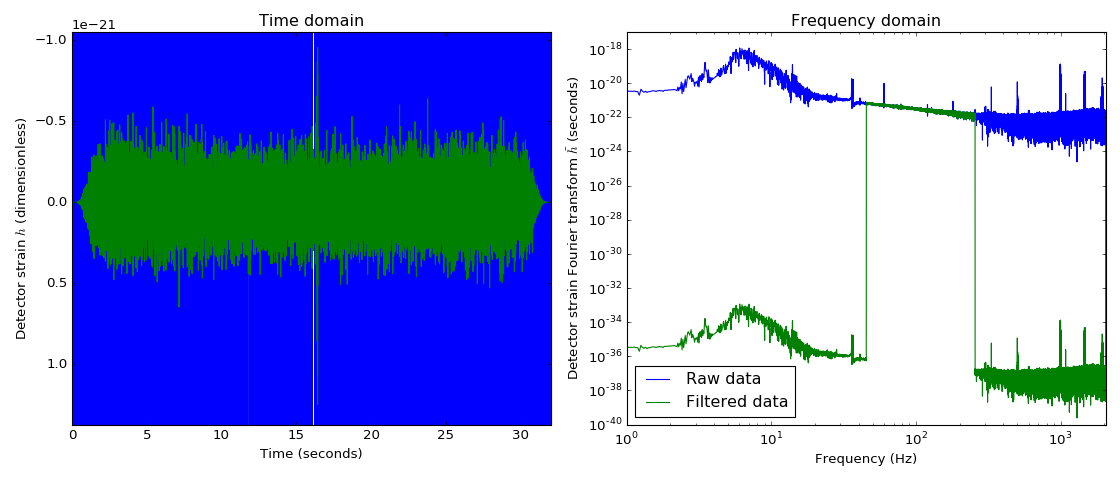

In [18]:
log2_sampling_rate = int(np.log2(sampling_rate/2))
frequency_bin_upper_ends = np.logspace(3, log2_sampling_rate, num=2*(log2_sampling_rate-3)+1, base=2)

gap_filler = widgets.Label("", layout=widgets.Layout(flex='1 1 auto'))
separator = widgets.VBox([], border='1px solid #ccc', width='0px')
use_equalizer = widgets.Checkbox(description='Use equalizer', value=True)
labels = widgets.VBox([widgets.Label("Frequency (Hz)"), gap_filler, use_equalizer, gap_filler, widgets.Label("Amplitude (dB)")], width='110px')
sliders = [widgets.FloatSlider(min=-15.0, max=15.0, step=0.5, value=0.0, height='auto', readout_format='+.1f',
                               orientation='vertical', padding=6, description=str(int(freq)))
           for freq in frequency_bin_upper_ends]
equalizer = widgets.HBox(children=[labels, separator]+sliders+[separator], height='200px')
display(equalizer)

notch_filters = widgets.VBox([], width='450px')
add_notch_filters = widgets.Button(description="Add notch filters")
add_notch_filters.on_click(lambda change: add_notch_filter(notch_filters, gap_filler))
display(add_notch_filters)
display(notch_filters)

recalculate_button = widgets.Button(description='Recalculate')
recalculate_button.on_click(lambda change: filter_and_plot(htilde, t, dt, sliders, notch_filters, use_equalizer, frequencies,
                                                           frequency_bin_upper_ends, hide_original_time_domain))
hide_original_time_domain = widgets.Checkbox(description='Hide raw t. d. data', value=False)
recalculate = widgets.HBox([recalculate_button, hide_original_time_domain])
display(recalculate)


cheat = True
if cheat:
    for f,s in zip(frequency_bin_upper_ends, sliders):
        if f<63 or f>257:
            s.value = -15.0
#         else:
#             s.value = 15.0
cheat = True
if cheat:
    notch_filters.children = tuple(widgets.HBox([widgets.FloatText(value=e, description='Begin', width='150px'),
                                                 widgets.FloatText(value=b, description='End', width='150px'),
                                                 gap_filler,
                                                 widgets.Checkbox(description='Use filter', value=True)])
                                   for e,b in [(59.8, 60.2), (119.5, 120.5), (179.0, 181.0)])
    #                                for e,b in [(59.8, 60.2), (119.5, 120.5), (179.0, 181.0), (35.5, 37.0), (40.85, 41.1)])
    #                                for e,b in [(59., 61.), (119.5, 120.5), (179.0, 181.0), (35.5, 37.0), (40.85, 41.1), (299., 304.), (331.4, 334.0)])


filter_and_plot(htilde, t, dt, sliders, notch_filters, use_equalizer, frequencies, frequency_bin_upper_ends, hide_original_time_domain)

1. Listen to raw data
  * Can we hear the signal?
  * What are the sources of noise here?
  * The raw data sounds generally very high-pitched.  But looking in the frequency domain, we see that most of the power is at low frequencies.  Why doesn't the raw data sound low-pitched?
2. Simple filtering
  * The actual signal peaks right in the middle of the data (at $t=16.4\,\mathrm{sec}$), and the peak frequency was around $250\,\mathrm{Hz}$.
  * Can you adjust the filters so that you can see the peak amplitude in the time domain?  Can you hear it?
  * If you leave the $45\,\mathrm{Hz}$ band in the data, you see (and hear) big slow oscillations in the time-domain amplitude.  Can you explain where these come from, and why they oscillate like that?
  * How does the largest data point of your filtered data (in the time domain) compare to the largest point in the raw data?  Why is this?
  * Why does LIGO take data for much higher frequencies than the ones needed to hear this signal?
  * If you zoom in on the plot of the data, there's just a small amount that looks like it might contain the actual signal.  About how much time would you say this lasts for?  Roughly how many cycles of data would you believe come from the GW150914 event, as opposed to noise?
3. Compare to numerical-relativity waveform
  * Plot the NR waveform along with the filtered data
  * How many cycles would you expect to be able to see in the filtered data, judging from the simulated data from numerical relativity?
  * Why do the NR waveform and the filtered data look so different?
  * How can you make them look more similar?
4. Improving filtering
  * How could we improve the filtering we've done here?
    * More frequency bins
    * Adjust equalizer proportionally to noise
    * Adjust equalizer proportionally to an expected signal
    * Use phase information of expected signal